In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Deep learning models

In [2]:
import zipfile

with zipfile.ZipFile("../data/cleaned/resale_price_normalized_demo.csv.zip", 'r') as zip_ref:
    file_name = zip_ref.namelist()[0] 
    with zip_ref.open(file_name) as file:
        df_resale = pd.read_csv(file)

/var/folders/pf/xn094ngs70lb3jh0xpvlzx8c0000gn/T/ipykernel_71838/2757938304.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


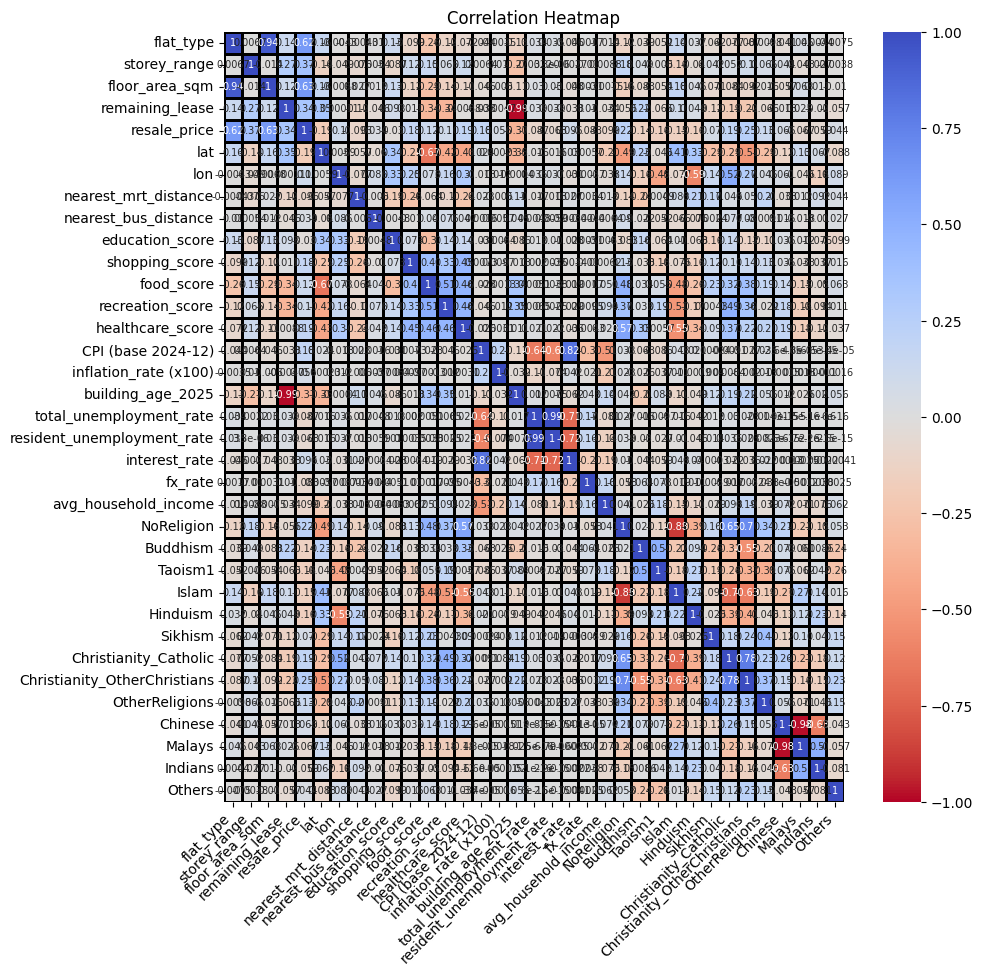

In [3]:
# Correlation heatmap
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df_resale.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [4]:
df_resale = df_resale.drop(columns=['remaining_lease'])

***Do we want to remove variables with high multicollinearity?

## Preprocessing

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df_resale['month'] = pd.to_datetime(df_resale['month'])
df_resale['year'] = df_resale['month'].dt.year.astype('int')

for col in df_resale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_resale[col] = le.fit_transform(df_resale[col])


X = df_resale.drop(columns=['resale_price', 'month'])
y = df_resale['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [6]:
df_resale

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,lat,lon,nearest_mrt_distance,...,Hinduism,Sikhism,Christianity_Catholic,Christianity_OtherChristians,OtherReligions,Chinese,Malays,Indians,Others,year
0,2017-03-01,4,0.333333,0.2500,0.083408,5,0.131278,0.000000,0.456109,0.159033,...,0.038491,0.006792,0.062642,0.123019,0.003774,0.786768,0.085986,0.097023,0.030223,2017
1,2017-05-01,4,0.333333,0.1250,0.083408,5,0.131197,0.000000,0.456109,0.159033,...,0.038491,0.006792,0.062642,0.123019,0.003774,0.786768,0.085986,0.097023,0.030223,2017
2,2017-03-01,4,0.333333,0.0625,0.083408,5,0.127206,0.002888,0.454289,0.170487,...,0.038491,0.006792,0.062642,0.123019,0.003774,0.786768,0.085986,0.097023,0.030223,2017
3,2017-12-01,4,0.333333,0.1875,0.116175,5,0.171393,0.002888,0.454289,0.170487,...,0.038491,0.006792,0.062642,0.123019,0.003774,0.786768,0.085986,0.097023,0.030223,2017
4,2017-01-01,4,0.333333,0.1250,0.101281,5,0.190853,0.005513,0.415298,0.035276,...,0.038491,0.006792,0.062642,0.123019,0.003774,0.786768,0.085986,0.097023,0.030223,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196981,2024-04-01,19,0.666667,0.0625,0.235329,5,0.263095,1.000000,0.429908,0.288495,...,0.053553,0.002490,0.054746,0.094928,0.002661,0.739422,0.142192,0.089282,0.029136,2024
196982,2024-07-01,19,0.666667,0.1250,0.235329,5,0.277557,1.000000,0.429908,0.288495,...,0.053553,0.002490,0.054746,0.094928,0.002661,0.739422,0.142192,0.089282,0.029136,2024
196983,2024-08-01,19,0.500000,0.2500,0.178731,8,0.240401,1.000000,0.429908,0.288495,...,0.053553,0.002490,0.054746,0.094928,0.002661,0.739422,0.142192,0.089282,0.029136,2024
196984,2024-10-01,19,0.666667,0.2500,0.238308,5,0.329079,1.000000,0.429908,0.288495,...,0.053553,0.002490,0.054746,0.094928,0.002661,0.739422,0.142192,0.089282,0.029136,2024


## Model Definition

### Simple Neural Network

In [7]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions = nn_model.predict(X_test_scaled)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


### RNN

In [8]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Predictions
rnn_predictions = rnn_model.predict(X_test_rnn)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


### LSTM

In [ ]:
Delete CPI, resale price adjusted by inflation

In [9]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.LSTM(50, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3940/3940 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - loss: 0.0081 - mae: 0.0524 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 2/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0018 - val_mae: 0.0339
Epoch 3/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - loss: 0.0011 - mae: 0.0236 - val_loss: 0.0023 - val_mae: 0.0390
Epoch 4/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 789us/step - loss: 9.5140e-04 - mae: 0.0226 - val_loss: 0.0022 - val_mae: 0.0383
Epoch 5/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 779us/step - loss: 9.1777e-04 - mae: 0.0222 - val_loss: 0.0022 - val_mae: 0.0379
Epoch 6/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 765us/step - loss: 8.8236e-04 - mae: 0.0218 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 7/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 776us/step - loss: 8.5051e-04 - mae: 0.0215 - val_loss: 0.0018 - val_mae: 0.0345
Epoch 8/100
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 3s 780us/step - loss: 8.2977e-04 - mae: 0.0212 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 9/

In [10]:
# Predictions
lstm_predictions = lstm_model.predict(X_test_rnn)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step


## Evaluation

In [11]:
def evaluate_model(true_values, predictions):
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    return r2, rmse, mae

nn_r2, nn_rmse, nn_mae = evaluate_model(y_test, nn_predictions)
print(f"Neural Network - R²: {nn_r2:.4f}, RMSE: {nn_rmse:.4f}, MAE: {nn_mae:.4f}")

rnn_r2, rnn_rmse, rnn_mae = evaluate_model(y_test, rnn_predictions)
print(f"RNN - R²: {rnn_r2:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}")

lstm_r2, lstm_rmse, lstm_mae = evaluate_model(y_test, lstm_predictions)
print(f"LSTM - R²: {lstm_r2:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")


Neural Network - R²: 0.8472, RMSE: 0.0373, MAE: 0.0276
RNN - R²: 0.3926, RMSE: 0.0743, MAE: 0.0610
LSTM - R²: 0.6019, RMSE: 0.0601, MAE: 0.0459
